### Combined Data Preprocessing Notebook
this notebook merges:
1. baseclean.py (initial cleaning)
2. program1 step4.py (variance threshold)
3. pj1_clark.py (additional preprocessing)

we start with **`congress_118_bills.csv`** and output **`final_congress_bills_data.csv`**.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

print("all libraries imported.")

all libraries imported.


#### 1) Primary preprocessing of raw data to create standardized dates, numerical values, categories (from `baseclean.py`)

In [ ]:
# step 1: base clean
# read original dataset and do initial cleaning steps

input_file = "congress_118_bills.csv"  # single input file
df = pd.read_csv(input_file)

print("initial dataset shape:", df.shape)

# extract introduced date from the raw text
df['Introduced'] = df['Introduced'].str.extract(r'([A-Za-z]+ \d{1,2}, \d{4})')
df['Introduced'] = pd.to_datetime(df['Introduced'], errors='coerce')

# convert vote date to datetime
df['Vote Date'] = pd.to_datetime(df['Vote Date'], errors='coerce')

# extract the main status date
df['Status Date'] = df['Status'].str.extract(r'\((.*?)\)')
df['Status Date'] = pd.to_datetime(df['Status Date'], errors='coerce')
df['Cleaned Status'] = df['Status'].str.extract(r'([A-Za-z ]+)')

# fix vote date for bills that are only 'Introduced'
df.loc[df['Cleaned Status'] == "Introduced", 'Vote Date'] = df['Introduced']

# clean up 'Related Bills'
df['Related Bills'] = df['Related Bills'].astype(str).str.strip(', ')

# extract just the primary committee
df['Committees'] = df['Committees'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# feature engineering: cosponsor count
df['Cosponsor Count'] = df['Cosponsor List'].apply(
    lambda x: len(x.split(',')) if isinstance(x, str) else 0
)
# binary column for having cosponsors
df['Has Cosponsors'] = df['Cosponsors (Overview)'].apply(
    lambda x: 1 if isinstance(x, str) and "Cosponsors" in x else 0
)

def manage_vote_columns(row):
    if isinstance(row['Vote Result'], str):
        if 'Last Action:' in row['Vote Result']:
            date_str = row['Vote Result'].split(':')[-1].strip()
            row['Vote Date'] = pd.to_datetime(date_str, errors='coerce')
            row['Vote Result'] = 'No Vote 0/0'
        elif 'Passed:' in row['Vote Result'] or 'Failed:' in row['Vote Result']:
            row['Vote Result'] = row['Vote Result'].split(':')[-1].strip()
    return row

df = df.apply(manage_vote_columns, axis=1)

# fix vote result if it's a date
def fix_vote_columns(row):
    if isinstance(row['Vote Result'], str):
        try:
            date_match = pd.to_datetime(row['Vote Result'], errors='coerce', exact=False)
            if pd.notnull(date_match):
                row['Vote Date'] = date_match.strftime('%Y-%m-%d')
                row['Vote Result'] = 'On Motion 1/0'
        except:
            pass
    return row

df = df.apply(fix_vote_columns, axis=1)

# standardize vote date format
df['Vote Date'] = pd.to_datetime(df['Vote Date'], errors='coerce')
df['Vote Date'] = df['Vote Date'].dt.strftime('%Y-%m-%d')

# handle 'Subjects' -> one-hot
unique_subjects = set()
df['Subjects'].dropna().apply(lambda x: unique_subjects.update(x.split(',')))

for subject in unique_subjects:
    df[subject.strip()] = df['Subjects'].apply(lambda x: 1 if subject in str(x) else 0)

# drop extra columns
show_more_columns = [f"show {i} more" for i in range(1, 10)]
columns_to_drop = ['Summary', 'Source URL', 'Cosponsors (Overview)', 'Cosponsor List', 'Status', 'Prognosis', 'Subjects'] + show_more_columns
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')

print("after base cleaning:", df.shape)

#intermediate file
df.to_csv("clean_congress_bills_data.csv", index=False)
print("saved -> clean_congress_bills_data.csv")

initial dataset shape: (1952, 16)


C:\Users\kashi\AppData\Local\Temp\ipykernel_36836\2890086517.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Vote Date'] = pd.to_datetime(df['Vote Date'], errors='coerce')
C:\Users\kashi\AppData\Local\Temp\ipykernel_36836\2890086517.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Status Date'] = pd.to_datetime(df['Status Date'], errors='coerce')
C:\Users\kashi\AppData\Local\Temp\ipykernel_36836\2890086517.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[subj

after base cleaning: (1952, 827)
saved -> clean_congress_bills_data.csv


#### 2) Variance threshold for subjects and other numerical features

In [3]:
# step 2: read the 'clean_congress_bills_data.csv' and apply variance threshold

df_filtered = pd.read_csv("clean_congress_bills_data.csv")
print("loaded -> clean_congress_bills_data.csv shape:", df_filtered.shape)

from sklearn.feature_selection import VarianceThreshold

# select numeric features
import numpy as np
num_features = df_filtered.select_dtypes(include=[np.number]).columns

# compute variance for all numeric
variance = df_filtered[num_features].var()
print("variance of numeric features:")
print(variance)

# set a threshold
vt = VarianceThreshold(threshold=0.01)

# fill missing with 0 for variance calc
X_num = df_filtered[num_features].fillna(0)
vt.fit(X_num)

features_to_keep = X_num.columns[vt.get_support()]
print("\nfeatures to keep:", list(features_to_keep))

features_to_drop = set(num_features) - set(features_to_keep)
print("\ndropping features:", features_to_drop)

df_filtered = df_filtered.drop(columns=list(features_to_drop))
print("after variance threshold:", df_filtered.shape)

# optionally save
df_filtered.to_csv("filtered_congress_bills_data.csv", index=False)
print("saved -> filtered_congress_bills_data.csv")

loaded -> clean_congress_bills_data.csv shape: (1952, 827)
variance of numeric features:
Cosponsor Count                               7447.642094
Has Cosponsors                                   0.167194
Canada                                           0.002556
Drug trafficking and controlled substances       0.015637
Fraud offenses and financial crimes              0.012650
                                                 ...     
Floods and storm protection                      0.000512
Health care costs and insurance                  0.016628
Crime prevention                                 0.008638
Office of Management and Budget (OMB)            0.001535
show 43 more                                     0.001024
Length: 816, dtype: float64

features to keep: ['Cosponsor Count', 'Has Cosponsors', 'Drug trafficking and controlled substances', 'Fraud offenses and financial crimes', 'Criminal investigation', 'Health care coverage and access', 'Budget process', 'Sex', 'Administrative l

#### 3) Missing Values, Imputation, Outliers
read from **`filtered_congress_bills_data.csv`** from another teammate and proceed.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize

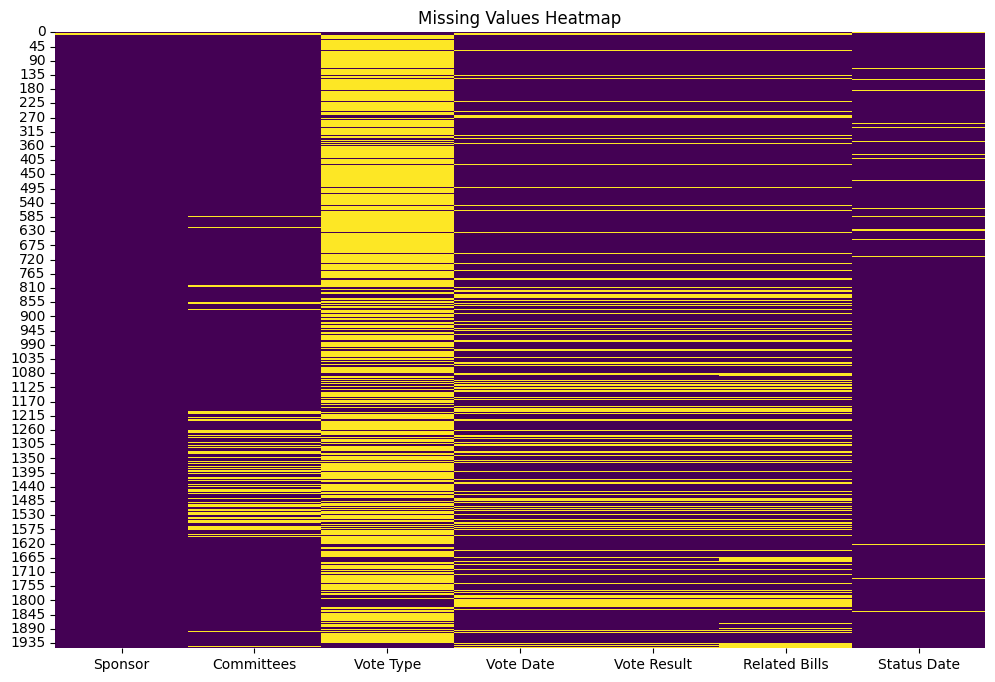

In [3]:
# read csv file
df = pd.read_csv('filtered_congress_bills_data.csv')

# find columns with missing values
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0].index

# only select the columns with missing values
df_missing = df[missing_columns]

# heatmap for missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df_missing.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

C:\Users\kashi\AppData\Local\Temp\ipykernel_9364\3705634699.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


columns after filling out with KNN:
Cosponsor Count                               0
Has Cosponsors                                0
Drug trafficking and controlled substances    0
Fraud offenses and financial crimes           0
Criminal investigation                        0
                                             ..
Agriculture and Food                          0
recognition                                   0
Child care and development                    0
Economics and Public Finance                  0
Health care costs and insurance               0
Length: 168, dtype: int64


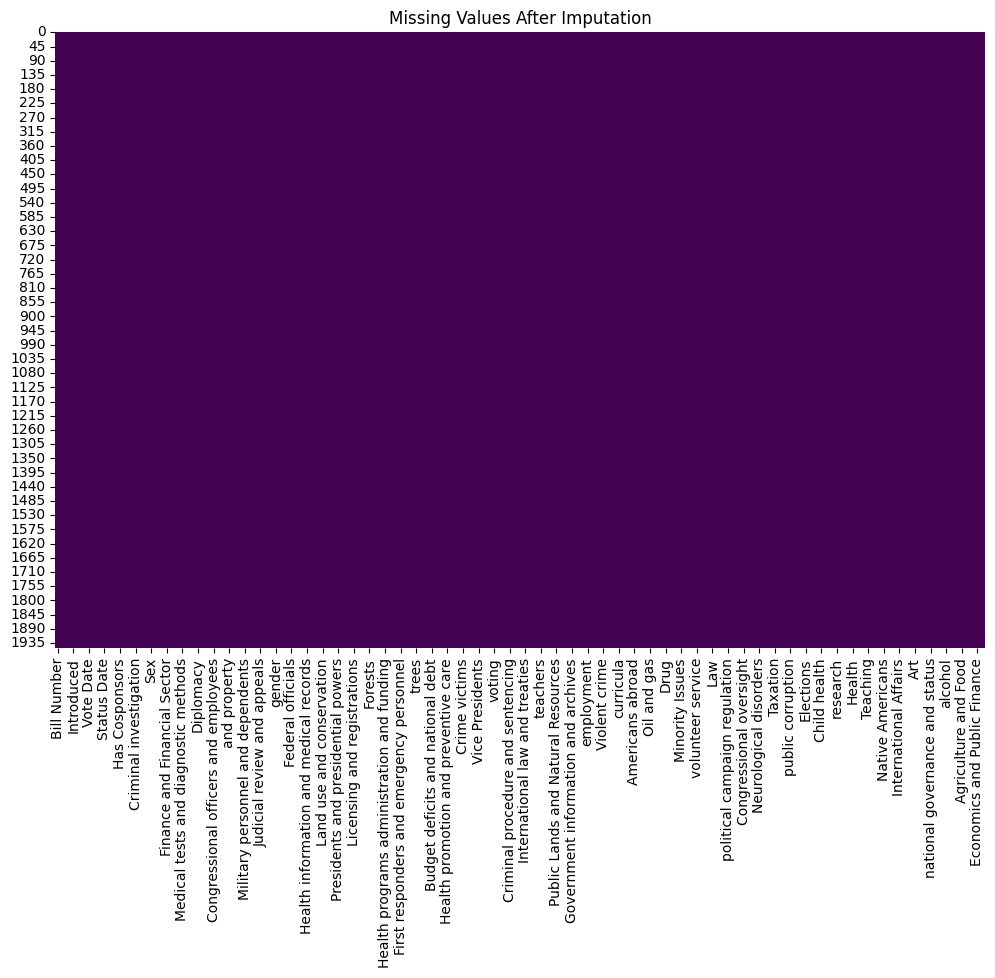

In [4]:
# choose column type
num_cols = df.select_dtypes(include=[np.number]).columns

# use knn
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

# use mode to fill out
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# show after 
print("columns after filling out with KNN:")
print(df[num_cols].isnull().sum())

# create heatmap again
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values After Imputation")
plt.show()

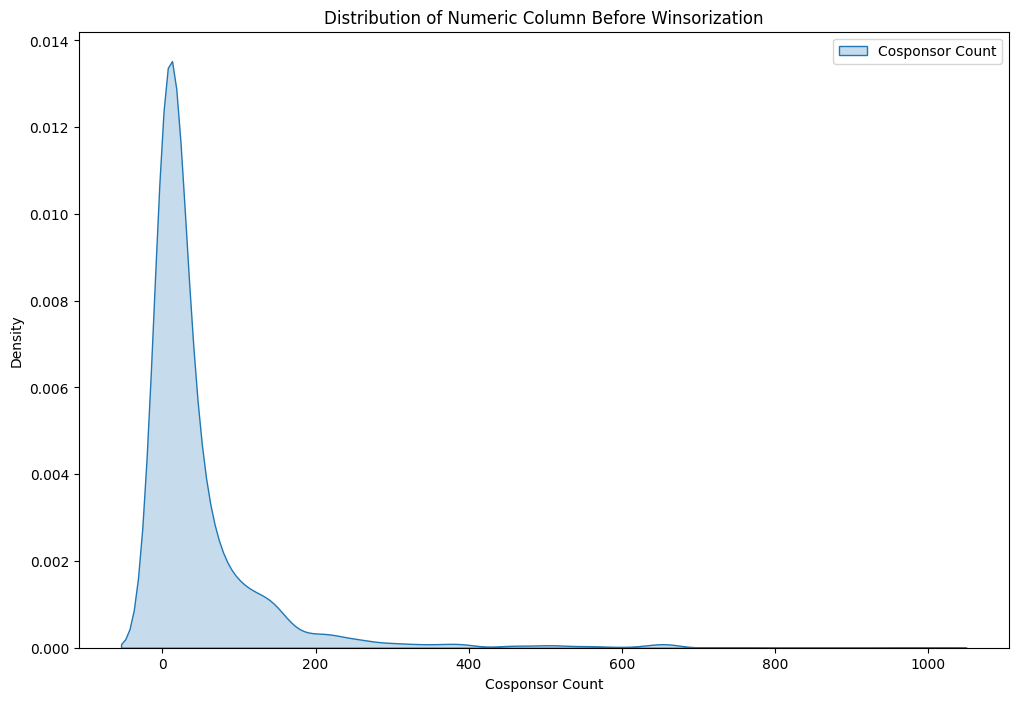

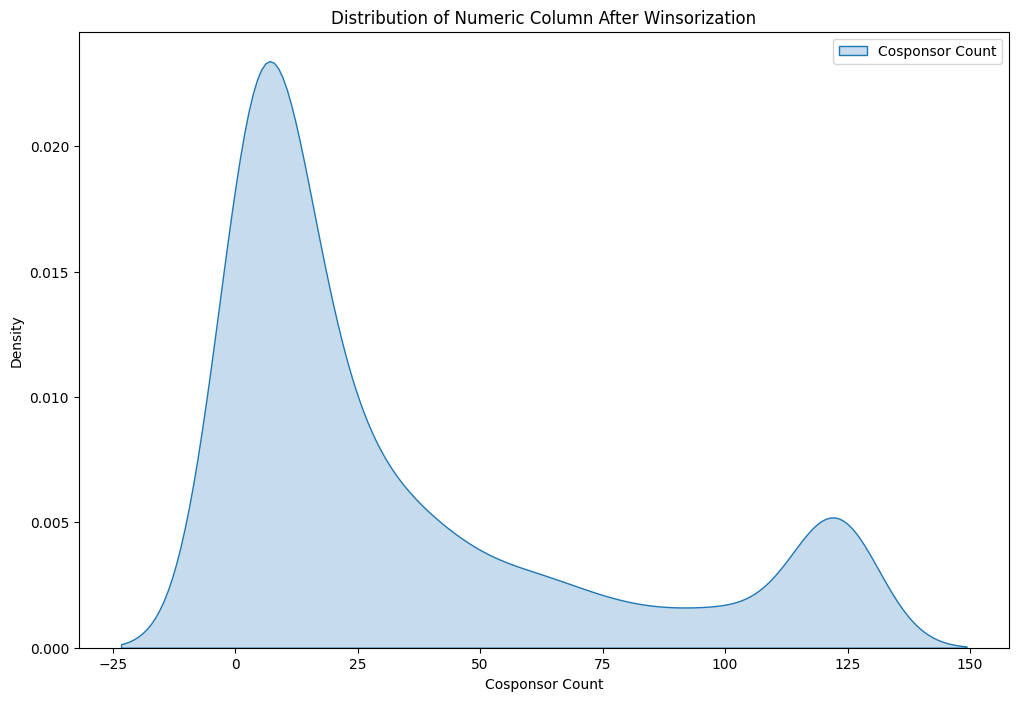

In [5]:
def winsorize_outliers(df, column, limits=[0.1, 0.1]):
    df[column] = winsorize(df[column], limits=limits)
    return df

#define numeric_columns
numeric_columns = num_cols

#plot the distribution of numeric column before winsorization
plt.figure(figsize=(12, 8))
for col in numeric_columns:
    if df[col].nunique() > 2:  # skip 0/1 columns
        sns.kdeplot(df[col], label=col, fill=True)
plt.title("Distribution of Numeric Column Before Winsorization")
plt.legend()
plt.show()

#winsorize outliers
for col in numeric_columns:
    if df[col].nunique() > 2:  # skip 0/1 columns
        df = winsorize_outliers(df, col)

#plot the distribution of numeric column after winsorization
plt.figure(figsize=(12, 8))
for col in numeric_columns:
    if df[col].nunique() > 2:  # skip 0/1 columns
        sns.kdeplot(df[col], label=col, fill=True)
plt.title("Distribution of Numeric Column After Winsorization")
plt.legend()
plt.show()

#reset index after winsorization
df.reset_index(drop=True, inplace=True)


In [7]:
df.to_csv('final_congress_bills_data.csv', index=False) #saving final dataset